In [80]:
%load_ext autoreload
%autoreload 2
%load_ext fortranmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [81]:
import sys
sys.path.append('../scripts/')

from time import time
import glob
import warnings
import param

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='paper', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [88]:
# %% MAIN
p = Parameters()
a = time()
liste = ['7786b-0200']
ds=[]
for l in liste:
    chi_dir = '../data/test_profiles/ema-'+l+'-tms.mat'
    tms = convert_tmsdata(chi_dir)
    ctd_dir = '../data/test_profiles/ema-'+l+'-ctd.mat'
    ctd = convert_ctddata(ctd_dir)

    turb = []
    for jblock in range(tms.time.size):
        
        tms_block = tms.isel(time=jblock)
        tms_block = prepare_data(tms_block, ctd)
#         tms_block['dof'] = 5
        tms_block = compute_chi(tms_block, p)
        tms_block = compute_rc_eps(tms_block, p)
        tms_block = compute_goto_eps(tms_block, p, bin_theory=True)
#         tms_block = qc_rc_eps(tms_block, p)
#         tms_block = mad(tms_block, p)
        tms_block = tms_block.swap_dims({'k_rpm': 'f_cps'})
        turb.append(tms_block)

    turb = xr.concat(turb, dim='time')
    ds.append(turb)

ds =  xr.concat(ds, dim='time')
ds['dof'] = ds.dof.isel(time=0)

b = (time()-a)/60
print(f'{b:2.2f} minutes')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 5000

In [ ]:
data_path = '../data/test_profiles/'
ds.to_netcdf(data_path+'variable_dof7.nc')

### Test likelihood estimation

In [53]:
0.5*(ds.f_cps[0].values+ds.f_cps[1].values)

0.15000000409781933

In [57]:
0.5*(ds.f_cps[0:-1].values+ds.f_cps[1:].values)

array([ 0.15      ,  0.2       ,  0.26250001,  0.36250001,  0.51250002,
        0.71250004,  0.97500005,  1.33750007,  1.85000005,  2.56250003,
        3.53750002,  4.87500006,  6.72500014,  9.28750038, 12.82500052,
       17.70000052, 24.42500114, 33.70000219, 46.48750305])

In [76]:
chi_dir = '../data/test_profiles/ema-'+l+'-tms.mat'
tms = convert_tmsdata(chi_dir)
ctd_dir = '../data/test_profiles/ema-'+l+'-ctd.mat'
ctd = convert_ctddata(ctd_dir)

In [77]:
tms

<xarray.Dataset>
Dimensions:  (f_cps: 20, time: 391)
Coordinates:
  * time     (time) datetime64[ns] 2017-09-25T06:40:35 ... 2017-09-25T07:45:35
  * f_cps    (f_cps) float64 0.125 0.175 0.225 0.3 ... 20.53 28.33 39.08 53.9
Data variables:
    sla1     (time, f_cps) int32 56 52 49 41 39 38 34 ... 63 63 60 54 46 43 37
    sla2     (time, f_cps) int32 56 52 49 41 39 38 34 ... 63 63 60 54 46 43 37
    dof      (f_cps) float64 4.0 4.0 4.0 8.0 ... 524.0 724.0 996.0 1.376e+03
Attributes:
    nobs:       391
    floatid:    7786b
    logavgoff:  10.0
    logavgsf:   1.0

In [ ]:
cond1 = tms_block.snr1 > p.snrmin
cond2 = tms_block.snr2 > p.snrmin
dof =   tms_block.where(cond1).dof.values
chi1 =  tms_block.where(cond1).chi1.values
chi2 =  tms_block.where(cond2).chi2.values
noise = tms_block.where(cond1).noise_rpm.values
k_rpm = tms_block.where(cond1).k_rpm.values
dtdz1 = tms_block.where(cond1).corrdTdzsp1_rpm.values
dtdz2 = tms_block.where(cond2).corrdTdzsp2_rpm.values

In [82]:
p = Parameters()
l = '7786b-0200'
chi_dir = '../data/test_profiles/ema-'+l+'-tms.mat'
tms = convert_tmsdata(chi_dir)
ctd_dir = '../data/test_profiles/ema-'+l+'-ctd.mat'
ctd = convert_ctddata(ctd_dir)

tms_block = tms.isel(time=100)
tms_block = prepare_data(tms_block, ctd)
tms_block = compute_chi(tms_block, p)
tms_block = compute_rc_eps(tms_block, p)
tms_block = compute_goto_eps(tms_block, p)

In [ ]:
cond1 = tms_block.snr1 > p.snrmin
cond2 = tms_block.snr2 > p.snrmin
dof =   tms_block.where(cond1).dof.values
chi1 =  tms_block.where(cond1).chi1.values
chi2 =  tms_block.where(cond2).chi2.values
noise = tms_block.where(cond1).noise_rpm.values
k_rpm = tms_block.where(cond1).k_rpm.values
dtdz1 = tms_block.where(cond1).corrdTdzsp1_rpm.values
dtdz2 = tms_block.where(cond2).corrdTdzsp2_rpm.values

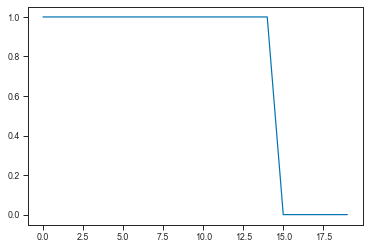

In [17]:
plt.plot( tms_block.snr1 > 3 )

In [65]:
cond1 = tms_block.snr1 > p.snrmin
cond2 = tms_block.snr2 > p.snrmin

dof = tms_block.where(cond1).dof.values
chi1 = tms_block.where(cond1).chi1.values
chi2 = tms_block.where(cond2).chi2.values
noise = tms_block.where(cond1).noise_rpm.values
k_rpm = tms_block.where(cond1).k_rpm.values
dtdz1 = tms_block.where(cond1).corrdTdzsp1_rpm.values
dtdz2 = tms_block.where(cond2).corrdTdzsp2_rpm.values

bin_theory = False
bounds =[(200,1000)]
options = {'maxiter':1000,'xatol':1e-3,'fatol':1e-3}
args = (k_rpm, chi1, noise, dtdz1, dof, 'Batchelor', bin_theory, p)

m = minimize(cost_function, x0=p.x0, args=args, method='Nelder-Mead', bounds=bounds, options=options)

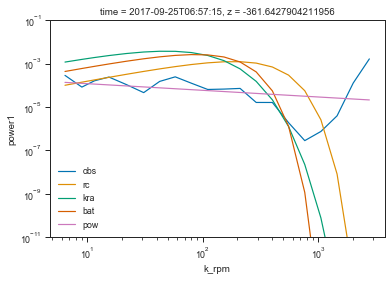

In [66]:
tms_block.corrdTdzsp1_rpm.plot(label='obs')
tms_block.bat1_rc.plot(label='rc')
tms_block.kra1.plot(label='kra')
tms_block.bat1.plot(label='bat')
tms_block.power1.plot(label='pow')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-11,1e-1)
plt.legend()